In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

plt.style.use('ggplot')

## Reading in the data

In [2]:
# Unzipping the limited dataset
# Data has been compressed for ease of use in Google Collab
# The original data has been limited to just 4 categories: 'angry', 'happy', 'neutral', and 'sad'

# If data is already unzipped this can be left commented out, otherwise uncomment the command to unzip
# the image files.


# !unzip ./content/limited.zip

In [2]:
# When unzipped the files will be in the 'limited' directory

# Test and train directories
train_dir = './limited/train'
test_dir = './limited/test'


# Train count
train_expression_list = [expression for expression in os.listdir(train_dir)]
train_count_dict = {}
for expression in train_expression_list:
    train_count_dict[expression] = len(
        os.listdir(train_dir + '/' + expression))


# Test count
test_expression_list = [expression for expression in os.listdir(test_dir)]
test_count_dict = {}
for expression in test_expression_list:
    test_count_dict[expression] = len(os.listdir(test_dir + '/' + expression))

# Printing out the number of images for each category
print("Train")
print(train_count_dict)
print()
print('Test')
print(test_count_dict)

Train
{'angry': 3995, 'happy': 7215, 'neutral': 4965, 'sad': 4830}

Test
{'angry': 958, 'happy': 1774, 'neutral': 1233, 'sad': 1247}


In [ ]:
# PERCENTAGES HERE

In [3]:
# Generating data from the images. This will add some shift, zoom, and rotation to the images
# to help the model learn better from a wider range.

train_datagen = ImageDataGenerator(rescale=1./255,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20)

train_set = train_datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(48, 48),
                                              shuffle=True,
                                              color_mode='grayscale',
                                              class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                            batch_size=32,
                                            target_size=(48, 48),
                                            shuffle=True,
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [4]:
# Checking the indicies for each expression

train_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

3995 angry 
7215 happy
4965 neutral
4830 sad

## Building the model

Since I am working with images I will use a convolutional neural network to predict expressions in the images. Building the model involves several functions from the Keras library.

`Sequential()` - A model comprised of stacks of layers moving from the initial input layer to the final output layer. Different types of layers can be used in the sequential model. More information on the sequential model can be found [here](https://keras.io/guides/sequential_model/).

`model.add(Conv2D())` - A 2D convolution layer for spatial convolution over images. These layers will use a filter to produce a feature map from the image. More information on 2D convolution layers can be found in the Keras documentation [here](https://keras.io/api/layers/convolution_layers/convolution2d/).

`model.add(MaxPooling2D())` - These layers reduce the number of parameters while keeping the important information. In max pooling the maximum value in each window on the feature map is kept. Pooling helps to shorten training time and prevent overfitting. More information on pooling layers can be found in the Keras documentation [here](https://keras.io/api/layers/pooling_layers/).

`model.add(Flatten())` - This flattens the input to 1D without affecting the batch size. Keras documentation on the flatten layer can be found [here](https://keras.io/api/layers/reshaping_layers/flatten/).

`model.add(Dense())` - Standard densely-connected neural network layer. This layer implements the operation passed in the activation argument. More information on dense layers can be found in the Keras documentation [here](https://keras.io/api/layers/core_layers/dense/).

There are a few arguments that need to be passed for each layer as well.

- Filter: This is the number seen first in each layer, it determines the number of output filters in the convolution. 
- kernel_size: Specifies the height and width of the 2D convolution window. In this model I use a kernel size of (3, 3) in each convolution layer.
- padding: set to "same" in each layer, this results in padding evenly to the edges of each input so that each output has the same height/width dimension as the input.
- activation: The activation function used by each layer. All layers are using a Rectified Linear Unit (relu) function except for the last layer, which is using a softmax function to make final predictions. More information on activation functions can be found in the Keras documentation [here](https://keras.io/api/layers/activations/).

In [5]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                 padding='same', input_shape=(48, 48, 1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

Now that the layers are added, we can generate a summary of the model.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

The next step is compiling the model. I will be using the Adam algorithm for the optimizer with a learning rate initially set at 0.0001. More information on the Adam optimizer can be found in the Keras documentation [here](https://keras.io/api/optimizers/adam/), and information on optimizers in Keras can be found [here](https://keras.io/api/optimizers/). Since there are multiple label classes I will be using the categorical crossentropy loss function. More information can be found in the Keras documentation [here](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class), and information on all loss functions in Keras can be found [here](https://keras.io/api/losses/). For metrics I will be using accuracy to calculate how often the predictions correctly match with the labels. More information on using accuracy in Keras can be found in the documentation [here](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class), and information on all metrics in Keras can be found [here](https://keras.io/api/metrics/).

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

Before fitting the model to the data I want to set up some callbacks. Callbacks can perform actions at various stages of the model, such as stopping the model before the stated number of epochs have elapsed, reducing the learning rate if needed, periodically saving the model, and more. Information on callbacks can be found in the Keras documentation [here](https://keras.io/api/callbacks/). 

In [8]:
# Stopping the model if the validation loss does not decrease
early_stop = EarlyStopping(monitor='val_loss', patience=4)

# Reducing the learning rate if the model starts to overfit
lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5,
                               verbose=1)

# Producing TensorBoard logs
tensorboard = TensorBoard(log_dir="logs", write_graph=True, write_images=True)

# Saving a model checkpoint
checkpoint = ModelCheckpoint('limited-set-best.h5', monitor='val_accuracy',
                             save_best_only=True, mode='auto')

The next step is fitting the model to the data. This part can be rather computationally intensive. I would recommend using a GPU to help with the processing of the model or using Google Collab with a GPU boost. Using a GPU greatly improves performance. Information on setting up a TensorFlow environment that uses a GPU can be found [here](https://www.tensorflow.org/install/gpu), and information on using Google Collab with GPU acceleration for TensorFlow models can be found [here](https://colab.research.google.com/notebooks/gpu.ipynb).

In [9]:
# For this notebook I have set the number of epochs to 15 as there is not much more to be gained
# after that point and it takes a bit for the early stop to kick in, so I have set it to stop at
# 15 epochs for ease of use.

history = model.fit(x=train_set, validation_data=test_set, epochs=15,
                    callbacks=[early_stop, lr_reducer, tensorboard,
                               checkpoint], verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 657 steps, validate for 163 steps
Epoch 1/15
657/657 [==============================] - 38s 59ms/step - loss: 1.3591 - accuracy: 0.3420 - val_loss: 1.3369 - val_accuracy: 0.3523
Epoch 2/15
657/657 [==============================] - 31s 48ms/step - loss: 1.3188 - accuracy: 0.3744 - val_loss: 1.1932 - val_accuracy: 0.4718
Epoch 3/15
657/657 [==============================] - 32s 48ms/step - loss: 1.1966 - accuracy: 0.4571 - val_loss: 1.0759 - val_accuracy: 0.5303
Epoch 4/15
657/657 [==============================] - 32s 48ms/step - loss: 1.0953 - accuracy: 0.5151 - val_loss: 0.9732 - val_accuracy: 0.5650
Epoch 5/15
657/657 [==============================] - 32s 49ms/step - loss: 0.9977 - accuracy: 0.5678 - val_loss: 0.9126 - val_accuracy: 0.6076
Epoch 6/15
657/657 [==============================] - 32s 49ms/step - loss: 0.9376 - accuracy: 0.5943 - val_loss: 0.8757 - val_accuracy: 0.6316
Epoch 7/15
657/657 [======================

## Evaluating Model Performance

The following graphs will display the training and testing loss of the model, as well as the accuracy over each epoch.

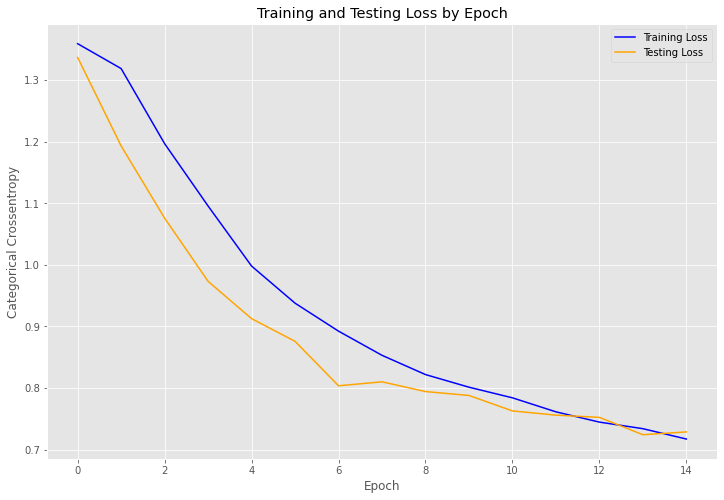

In [10]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.legend();

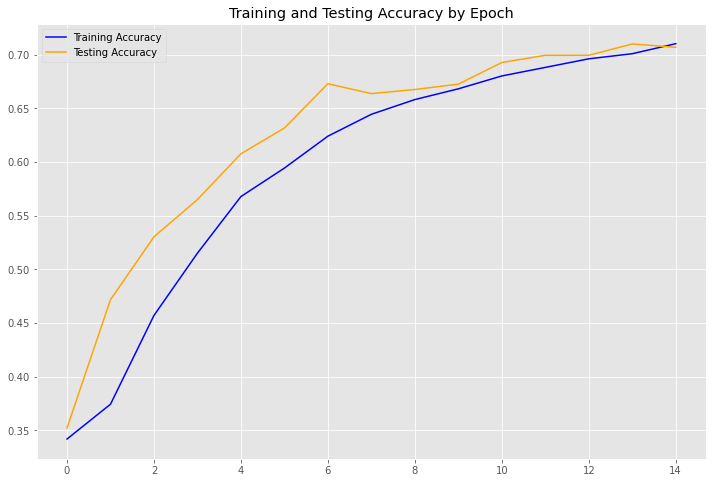

In [11]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(test_acc, label='Testing Accuracy', color='orange')
plt.title('Training and Testing Accuracy by Epoch')
plt.legend();

In [25]:
# Confusion matrix

preds = model.predict_generator(generator=test_set)
preds

array([[1.0613140e-01, 2.1898201e-02, 5.0049561e-01, 3.7147483e-01],
       [1.9863728e-02, 9.5815885e-01, 1.8967828e-02, 3.0095796e-03],
       [3.4292236e-01, 1.6268416e-03, 2.2282887e-01, 4.3262196e-01],
       ...,
       [1.4701432e-02, 6.0281616e-01, 3.2722586e-01, 5.5256449e-02],
       [1.6021945e-02, 9.8350137e-01, 3.3017094e-04, 1.4658403e-04],
       [1.5064039e-03, 9.9776018e-01, 5.3657551e-04, 1.9680864e-04]],
      dtype=float32)

In [33]:
pred_classes = np.argmax(preds, axis = 1)
pred_classes

array([2, 1, 3, ..., 1, 1, 1], dtype=int64)

In [29]:
true = test_set.classes
true

array([0, 0, 0, ..., 3, 3, 3])

In [37]:
cm = confusion_matrix(true, pred_classes)
cm

array([[163, 325, 228, 242],
       [304, 673, 381, 416],
       [219, 429, 281, 304],
       [202, 500, 266, 279]], dtype=int64)

In [39]:
labels = ['Angry', 'Happy', 'Neutral', 'Sad']

No handles with labels found to put in legend.


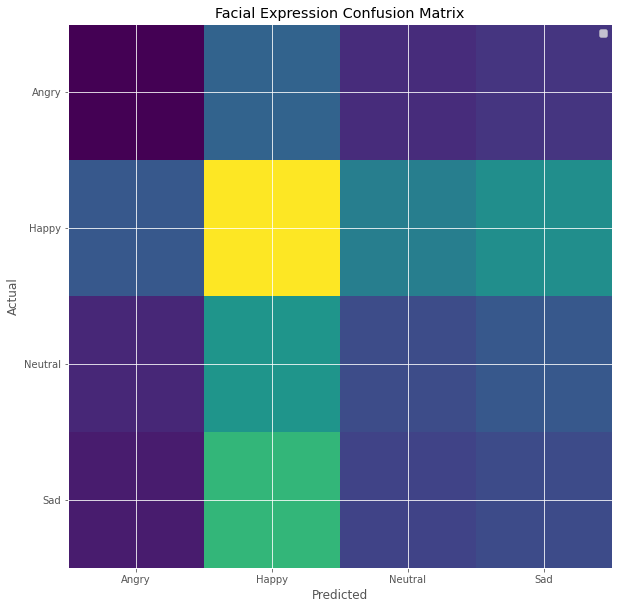

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.title('Facial Expression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = range(len(labels)), labels = labels)
plt.yticks(ticks = range(len(labels)), labels = labels)
plt.legend()

No handles with labels found to put in legend.


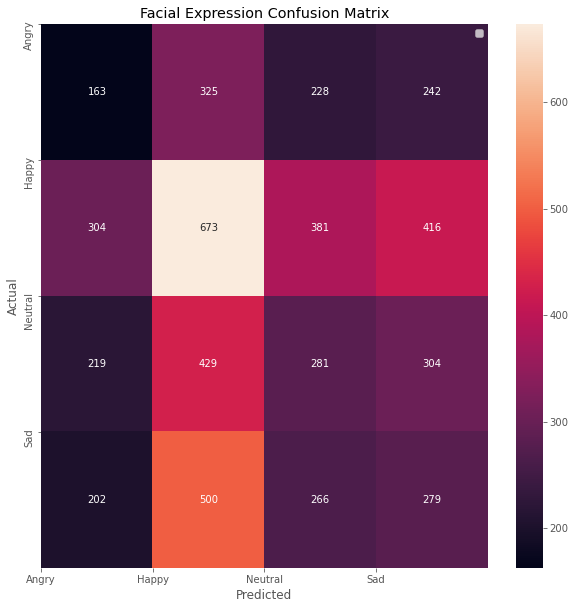

In [55]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Facial Expression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = range(len(labels)), labels = labels)
plt.yticks(ticks = range(len(labels)), labels = labels)
plt.legend()